# Lab Report of Group 1 (Wörner, Velez, Northe)

The source code and the binaries from the spectrum analyzer from this report can be found in our Github [repository](https://github.com/NortheLo/Microwave_Eng_Lab/tree/main/Lab4_Noise_Figures).

### Our used imports

In [65]:
import re
import numpy as np
from numpy.typing import NDArray
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.io.matlab import loadmat
from scipy.stats import linregress

### Some helper functions to keep the evaluation code short 

In [66]:
def read_mat(file_path: str | Path, dic_name: str) -> tuple[NDArray, NDArray, NDArray]:
    """
    Get the Gain, NF and f vector from the signal analyzer matlab file.
    """
    ws = loadmat(file_path)
    ws = ws[dic_name]

    gain = ws['gain'][0, 0].flatten()
    noise = ws['noise'][0, 0].flatten()
    f_steps = ws['f'][0, 0].flatten()

    return gain, noise, f_steps

def read_spec_csv(file_path: Path) -> tuple[list, NDArray, NDArray]:
    """
    Reads the CSV from the Spectrum Analyzer and puts the Metadata in a list, the freq bins and power
    into Numpy Arrays
    """
    # Read the entire CSV file
    with open(file_path, 'r') as f:
        content = f.read()

    # Split content into metadata and data sections using regex to find "DATA"
    parts = re.split(r'\bDATA\b', content)
    
    # Check if "DATA" section was found
    if len(parts) != 2:
        raise ValueError("No DATA section found in the file.")

    metadata_section = parts[0].strip()  # Everything before DATA
    data_section = parts[1].strip()      # Everything after DATA

    # Parse the metadata section
    metadata = {}
    for line in metadata_section.splitlines():
        if ',' in line:
            key, value = line.split(',', 1)
            metadata[key.strip()] = value.strip()

    # Parse the data section (split by newline, then split by comma)
    data = []
    for line in data_section.splitlines():
        if ',' in line:
            try:
                x, y = map(float, line.split(','))
                data.append([x, y])
            except ValueError:
                print(f"Skipping invalid line: {line}")
    
    # Convert data into numpy arrays
    data = np.array(data)
    frequencies = data[:, 0]  # First column (Frequency)
    values = data[:, 1]       # Second column (Values)

    return metadata, frequencies, values

def scientific_2_str(value: float, unit: str = "Ω") -> str:
    prefixes = [
        (1e9, 'G'),
        (1e6, 'M'),
        (1e3, 'k'),
        (1, ''),
        (1e-3, 'm'),
        (1e-6, 'µ'),
        (1e-9, 'n'),
        (1e-12, 'p')
    ]

    for factor, prefix in prefixes:
        if abs(value) >= factor:
            formatted = value / factor
            return f"{formatted:.3g} {prefix}{unit}"
    return f"{value:.3g} {unit}"  # fallback for very small values

def plot_compare(x1: NDArray, y1: NDArray,
                 x2: NDArray, y2: NDArray,
                 title: str,
                 x_label: str="Resistance [Ohm]",
                 y_label: str="Frequency [Hz]",
                 x_log: bool=False,
                 y_log: bool=False,
                 label1: str="Measurement 1",
                 label2: str="Measurement 2",
                 marker1: str='o',
                 marker2: str='s'):
    """
    Plots two datasets (x1, y1) and (x2, y2) on the same plot.
    This function assumes that x1 and x2 are frequency bins and y1 and y2 are the corresponding power bins.
    """
    
    # Align the bins to their corresponding measurements
    plt.figure(figsize=(8, 4))

    # Check if data requires log scaling
    if x_log and y_log:
        plt.loglog(x1, y1, marker=marker1, label=label1)
        plt.loglog(x2, y2, marker=marker2, label=label2)
    elif x_log:
        plt.semilogx(x1, y1, marker=marker1, label=label1)
        plt.semilogx(x2, y2, marker=marker2, label=label2)
    elif y_log:
        plt.semilogy(x1, y1, marker=marker1, label=label1)
        plt.semilogy(x2, y2, marker=marker2, label=label2)
    else:
        plt.plot(x1, y1, marker=marker1, label=label1)
        plt.plot(x2, y2, marker=marker2, label=label2)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot(x: NDArray, 
             y: NDArray,
             title: str,
             x_label: str="Resistance [Ohm]",
             y_label: str="Frequency [Hz]",
             x_log: bool=False,
             y_log: bool=False,
             marker: str='o'):

    plt.figure(figsize=(8, 4))

    if x_log and y_log:
        plt.loglog(x, y, marker=marker)
    elif x_log:
        plt.semilogx(x, y, marker=marker)
    elif y_log:
        plt.semilogy(x, y, marker=marker)
    else:
        plt.plot(x, y, marker=marker)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Convert power from dBm to linear scale (mW)
def dbm_to_mw(dbm):
    return 10**(dbm / 10)

def compute_and_plot_cascade_with_measured(
    f_lna: NDArray, gain_lna_db: NDArray, nf_lna_db: NDArray,
    f_att: NDArray, gain_att_db: NDArray, nf_att_db: NDArray,
    f_meas: NDArray, gain_meas_db: NDArray, nf_meas_db: NDArray,
    title: str = "5.4 LNA → 6 dB Attenuator: Measured vs Theoretical",
    x_label: str = "$f$ in $[Hz]$", y_label: str = "$P$ in $[dBm]$"
) -> tuple[NDArray, NDArray, NDArray]:
    """
    Plots measured and theoretical NF and gain for the cascade LNA → Attenuator.
    """
    from scipy.interpolate import interp1d

    def db_to_linear(db): return 10**(db / 10)
    def linear_to_db(lin): return 10 * np.log10(lin)

    # Interpolation base: common range across all three datasets
    f_min = max(f_lna.min(), f_att.min(), f_meas.min())
    f_max = min(f_lna.max(), f_att.max(), f_meas.max())
    f_common = np.linspace(f_min, f_max, num=300)

    # Interpolate all to common frequency base
    G1 = db_to_linear(interp1d(f_lna, gain_lna_db, kind='linear', fill_value='extrapolate')(f_common))
    F1 = db_to_linear(interp1d(f_lna, nf_lna_db, kind='linear', fill_value='extrapolate')(f_common))
    G2 = db_to_linear(interp1d(f_att, gain_att_db, kind='linear', fill_value='extrapolate')(f_common))
    F2 = db_to_linear(interp1d(f_att, nf_att_db, kind='linear', fill_value='extrapolate')(f_common))

    # Compute theoretical cascade using Friis
    G_total = G1 * G2
    F_total = F1 + (F2 - 1) / G1

    # Convert to dB
    gain_theo_db = linear_to_db(G_total)
    nf_theo_db = linear_to_db(F_total)

    # Interpolate measured cascade to f_common
    gain_meas_interp = interp1d(f_meas, gain_meas_db, kind='linear', fill_value='extrapolate')(f_common)
    nf_meas_interp = interp1d(f_meas, nf_meas_db, kind='linear', fill_value='extrapolate')(f_common)

    # Plot all four curves
    plt.figure(figsize=(9, 4))
    plt.plot(f_common, gain_meas_interp, label="Gain (Measured)", linestyle='-')
    plt.plot(f_common, nf_meas_interp, label="Noise Figure (Measured)", linestyle='-')
    plt.plot(f_common, gain_theo_db, label="Gain (Theoretical)", linestyle='--')
    plt.plot(f_common, nf_theo_db, label="Noise Figure (Theoretical)", linestyle='--')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return f_common, gain_theo_db, nf_theo_db


### Overview of Measurement Files
Files can be found under ``Meassurements/``

| File Name                     | Description                                       |
|------------------------------|---------------------------------------------------|
| `meassurement_5_1.mat`       | NF measurement of a filter         |
| `meassurement_5_2.mat`       | NF measurement of an attenuator                   |
| `meassurement_5_3.mat`       | NF measurement of LNA     |
| `meassurement_5_4.mat`       | NF of LNA → Attenuator |
| `meassurement_5_4_inverse.mat` | NF of Attenuator → LNA |


### CSV-File Overview
Files can be found under ``Meassurements/``
| Filename            | Description            |
|---------------------|------------------------|
| `Ampcor_0001.csv`   | no DUT + no NS         |
| `Ampcor_0002.csv`   | no DUT + NS            |
| `Ampcor_0003.csv`   | DUT + no NS            |
| `Ampcor_0004.csv`   | DUT + NS               |

## 5.1 Filter

We calculated the results below with some MATLAB code.

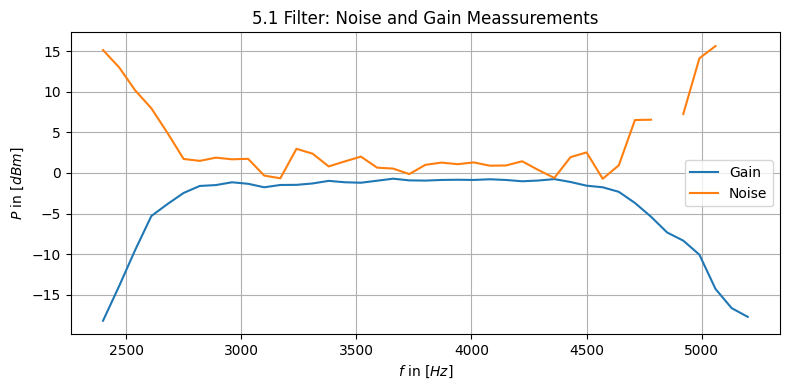

In [67]:
title_filter = "5.1 Filter: Noise and Gain Meassurements"
filter_gain, filter_noise, filter_f_steps = read_mat('Meassurements/meassurement_5_1.mat', 'messung_5_1_filter')


plot_compare(x1=filter_f_steps, y1=filter_gain,
             x2=filter_f_steps, y2=filter_noise,
             title=title_filter, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[Hz]$",
             y_label="$P$ in $[dBm]$")

In [68]:
# search all the indices which are below our 3dB threshold
# and then search for the last and the first one
peak_gain = np.max(filter_gain)
threshold = peak_gain - 3

crossing_indices = np.where(filter_gain <= threshold)[0]

if crossing_indices.size >= 2:
    peak_index = np.argmax(filter_gain)
    
    lower_idx = crossing_indices[crossing_indices < peak_index][-1]
    f1, f2 = filter_f_steps[lower_idx], filter_f_steps[lower_idx + 1]
    g1, g2 = filter_gain[lower_idx], filter_gain[lower_idx + 1]
    f_3db_low = f1 + (threshold - g1) * (f2 - f1) / (g2 - g1)

    upper_idx = crossing_indices[crossing_indices > peak_index][0]
    f1, f2 = filter_f_steps[upper_idx - 1], filter_f_steps[upper_idx]
    g1, g2 = filter_gain[upper_idx - 1], filter_gain[upper_idx]
    f_3db_high = f1 + (threshold - g1) * (f2 - f1) / (g2 - g1)
    f_center = (f_3db_high - f_3db_low) / 2 + f_3db_low

    print(f"Lower -3 dB frequency: {f_3db_low:.2f} Hz")
    print(f"Upper -3 dB frequency: {f_3db_high:.2f} Hz")
    print(f"Estimated center frequency: {f_center:.2f} Hz")
else:
    print("Could not find two -3 dB crossing points.")



Lower -3 dB frequency: 2686.30 Hz
Upper -3 dB frequency: 4710.45 Hz
Estimated center frequency: 3698.38 Hz


In [69]:
# we divide as we have steps normed to MHz 
f_min = 3e9 / 1e6
f_max = 4.3e9 / 1e6 

mask = (filter_f_steps >= f_min) & (filter_f_steps <= f_max)
gain_in_band = filter_gain[mask]

if gain_in_band.size > 0:
    gain_max = np.max(gain_in_band)
    gain_min = np.min(gain_in_band)
    ripple = gain_max - gain_min

    print(f"Transmission ripple between 3 GHz and 4.3 GHz: {ripple:.2f} dB")
else:
    print("No data points found in the 3 GHz to 4.3 GHz range.")

Transmission ripple between 3 GHz and 4.3 GHz: 1.06 dB


## 5.2 Attenuator (6 dB)

The frequency response of the 6 dB attenuator is shown in Figure 2. As expected for a passive, linear component, both the gain and the noise figure are nearly constant across the measured frequency range of 200 MHz to 6 GHz. The measured gain is approximately –6 dB throughout, closely matching the nominal attenuation value of the device. Hence:

$$
G = -6 \text{dB}
$$

From a theoretical standpoint, for a passive network at ambient temperature \( T \approx T_0 = 290\,\text{K} \), the noise figure is given by:

$$
F = 1 + (L - 1)\frac{T}{T_0}
$$

where \( L \) is the linear loss. At \( T = T_0 \), this simplifies to \( F = L \), and in dB:

$$
F_{\text{dB}} = L_{\text{dB}} = 6\,\text{dB}
$$

The experimental results confirm this theoretical expectation. The gain remains consistently around –6 dB across the entire frequency sweep, and the noise figure is likewise flat, averaging close to 6 dB. This behavior is characteristic of a broadband, resistive attenuator, which introduces thermal noise equivalent to its loss when matched and operated at room temperature.


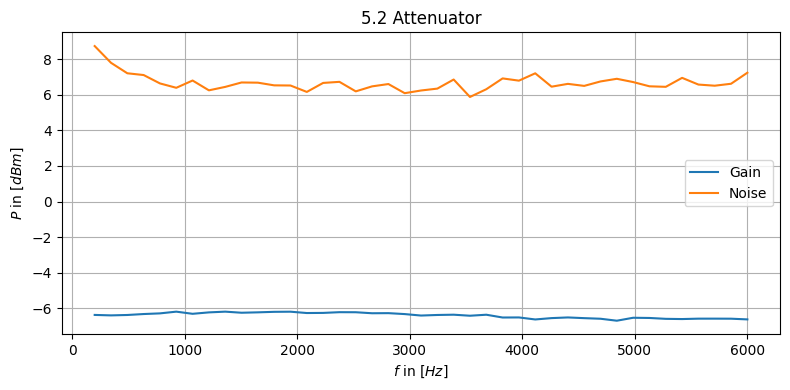

In [70]:
title_att = "5.2 Attenuator"
att_gain, att_noise, att_f_steps  = read_mat('Meassurements/meassurement_5_2.mat', 'messung_5_2_att')

plot_compare(x1=att_f_steps, y1=att_gain,
             x2=att_f_steps, y2=att_noise,
             title=title_att, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[Hz]$",
             y_label="$P$ in $[dBm]$")

#### Additional Note: Low-Frequency Noise Behavior

An additional log-log plot of the noise power below 1 kHz reveals a consistent downward trend with a fitted slope of –0.34 and \( R^2 = 0.986 \), suggesting a mild frequency dependence. While this behavior resembles 1/f noise in form, the slope is far shallower than the typical value (≈ –1), and since the DUT is a purely passive attenuator, it is unlikely that this is genuine 1/f noise originating from the device.

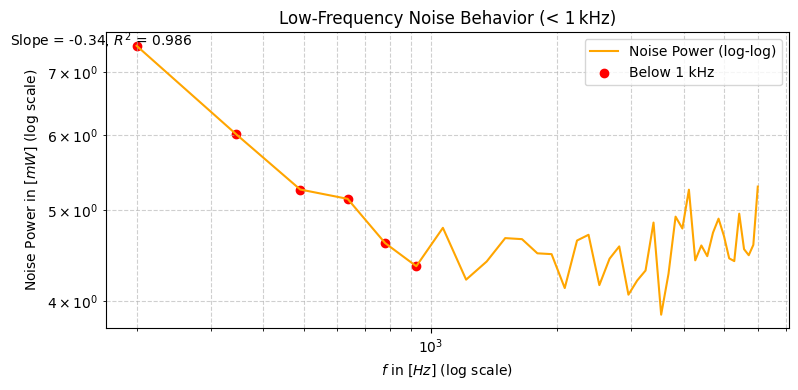

In [71]:
# Convert inputs
freq_hz = np.array(att_f_steps)
noise_dbm = np.array(att_noise)
noise_mw = dbm_to_mw(noise_dbm)

# Filter: keep only frequencies < 1000 Hz
mask = freq_hz < 1000
log_f = np.log10(freq_hz[mask])
log_p = np.log10(noise_mw[mask])

# Linear regression on log-log
slope, intercept, r_value, _, _ = linregress(log_f, log_p)

# Plot
plt.figure(figsize=(8, 4))
plt.loglog(freq_hz, noise_mw, label='Noise Power (log-log)', color='orange')
plt.scatter(freq_hz[mask], noise_mw[mask], color='red', label='Below 1 kHz')

# Annotate slope
plt.text(100, max(noise_mw[mask]), f"Slope = {slope:.2f}, $R^2$ = {r_value**2:.3f}", fontsize=10)

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xlabel('$f$ in $[Hz]$ (log scale)')
plt.ylabel('Noise Power in $[mW]$ (log scale)')
plt.title("Low-Frequency Noise Behavior (< 1 kHz)")
plt.legend()
plt.tight_layout()
plt.show()

A more plausible explanation is a systematic artifact such as residual instrument 1/f noise, mismatch effects at low frequencies, or averaging limitations. Therefore, this observation is not attributed to the attenuator's intrinsic behavior but is still worth noting for completeness.

## 5.3 Low noise amplifier (LNA)

Insert result here

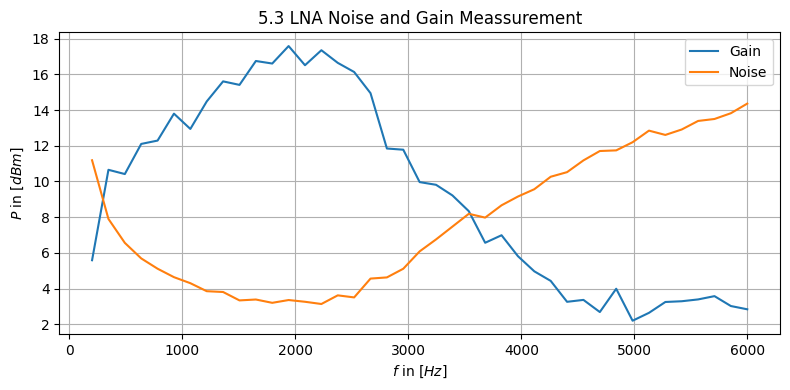

In [72]:
title_lna = "5.3 LNA Noise and Gain Meassurement"
lna_gain, lna_noise, lna_f_steps = read_mat('Meassurements/meassurement_5_3.mat', 'messung_5_3_LNA')


plot_compare(x1=lna_f_steps, y1=lna_gain,
             x2=lna_f_steps, y2=lna_noise,
             title=title_lna, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[Hz]$",
            y_label="$P$ in $[dBm]$")

In [73]:
max_gain = np.max(lna_gain)
f_max_gain = lna_f_steps[np.argmax(lna_gain)]
print(f"LNA gain is max @ {f_max_gain} Hz with {max_gain:.2f} dB")

min_noise = np.min(lna_noise)
f_min_noise = lna_f_steps[np.argmin(lna_noise)]
print(f"LNA noise is min @ {f_min_noise} Hz with {min_noise:.2f} dB")


LNA gain is max @ 1940 Hz with 17.59 dB
LNA noise is min @ 2230 Hz with 3.13 dB


## 5.4 LNA with subsequent 6 dB attenuator

#### LNA Followed by Attenuator

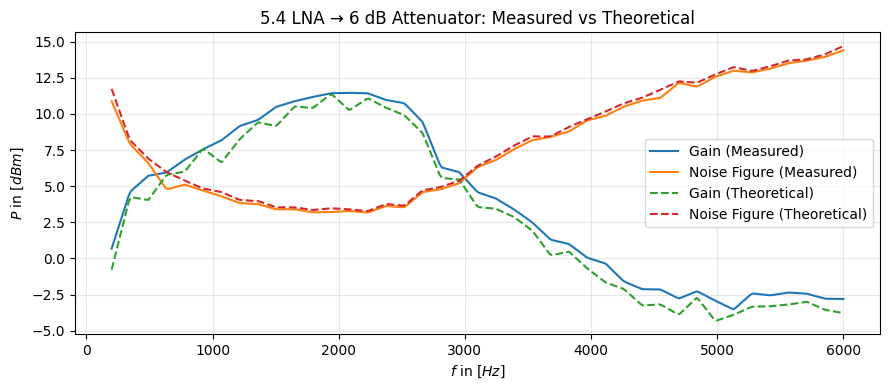

In [74]:
title_lna_att = "5.4 LNA -> $6$dB Attenuator"
lna_att_gain, lna_att_noise, lna_att_f_steps = read_mat('Meassurements/meassurement_5_4.mat', 'messung_5_4_LNA_Att')

# Compute and plot all
f_plot, gain_theo, nf_theo = compute_and_plot_cascade_with_measured(
    f_lna=lna_f_steps, gain_lna_db=lna_gain, nf_lna_db=lna_noise,
    f_att=att_f_steps, gain_att_db=att_gain, nf_att_db=att_noise,
    f_meas=lna_att_f_steps, gain_meas_db=lna_att_gain, nf_meas_db=lna_att_noise
)

In this configuration, the low-noise amplifier (LNA) is followed by a 6 dB attenuator. The measured gain is consistent with theoretical expectations: compared to the standalone LNA (Section 5.3), the gain curve is approximately 6 dB lower, as expected from adding a fixed attenuator after the amplifier.

To estimate the theoretical noise figure of the cascade, we apply the **Friis formula** for two components:

$$
F_{\text{total}} = F_1 + \frac{F_2 - 1}{G_1}
$$

Where:
- \( F_1 \): noise factor of the LNA (converted from NF in dB)
- \( F_2 \): noise factor of the attenuator
- \( G_1 \): gain of the LNA (linear)

Since the attenuator is passive and operates at room temperature \( T = T_0 \), its noise figure is equal to its loss (i.e., \( F_2 = 10^{6/10} = 3.98 \)). The gain and NF of the LNA were taken from the previous measurement. The resulting theoretical curve matches well with the measured noise figure, validating the cascading behavior and low added noise from placing the LNA first.

---

#### Attenuator Followed by LNA

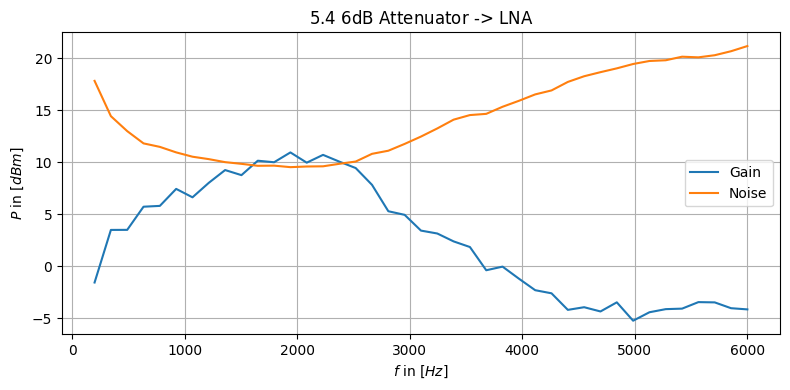

In [75]:
title_att_lna = "5.4 $6$dB Attenuator -> LNA"
att_lna_gain, att_lna_noise , att_lna_f_steps = read_mat('Meassurements/meassurement_5_4_inverse.mat', 'messung_5_4_LNA_Att_reverse')

plot_compare(x1=att_lna_f_steps, y1=att_lna_gain,
             x2=att_lna_f_steps, y2=att_lna_noise,
             title=title_att_lna, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[Hz]$",
             y_label="$P$ in $[dBm]$")

In contrast, when the attenuator is placed before the LNA, the overall system gain remains roughly the same, but the noise figure is significantly higher, especially at higher frequencies.

This behavior is predicted by the Friis formula:

$$
F_{\text{swapped}} = F_2 + \frac{F_1 - 1}{G_2}
$$

Here, F_2 is now the dominant term, since it comes first. The LNA still amplifies the signal and noise, but the attenuator has already degraded the signal-to-noise ratio by introducing thermal noise and reducing signal power. The result is a higher system noise figure, as seen in the plot, particularly because the first component in the chain dominates the overall noise performance.

---

## 5.5 Noise figure measurement of the LNA with Y-Factor method

$\red {Remove \space this  \space example}$ <br>
This is used as a test if we can load in the csv file at all

In [76]:


meta_data, freq_bins, pwr_bins = read_spec_csv("Meassurements/Ampcor_0001.csv")

title_filter = "Task 3.2.3 a): "
plot(freq_bins, pwr_bins, title_filter, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed